In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
import time
from sklearn.metrics import mean_squared_log_error
def custom_metric(y_true, y_preds):
    return np.sqrt(mean_squared_log_error(y_true, y_preds))
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred) ** 0.5
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import *
from kmodes.kmodes import KModes

In [4]:
train_data = "train.csv"
test_data = "test.csv"
submission_file_path = "sample_submission.csv"

train  = pd.read_csv(train_data)
test  = pd.read_csv(test_data)
train.shape , test.shape

((89392, 12), (59595, 11))

In [5]:
## Exploring dependent variable

In [6]:
train['cltv'].describe()

count     89392.000000
mean      97952.828978
std       90613.814793
min       24828.000000
25%       52836.000000
50%       66396.000000
75%      103440.000000
max      724068.000000
Name: cltv, dtype: float64

<AxesSubplot:>

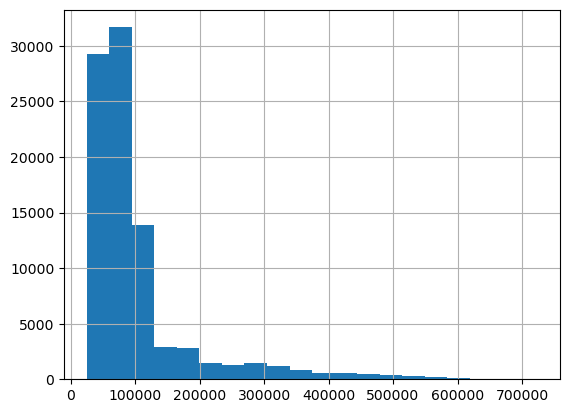

In [7]:
train.cltv.hist(bins=20) ## positively skewed

In [8]:
from scipy import stats
import numpy as np

# Generate some data
data = train['cltv']

# Perform the Box-Cox transformation
transformed_data, lambda_ = stats.boxcox(data)

# Print the optimal lambda value
print(lambda_)


-0.5263936553018757


In [9]:
train['cltv1'] = 1/np.sqrt(train['cltv'])
train['cltv2'] = np.log(train['cltv']+1)

<AxesSubplot:>

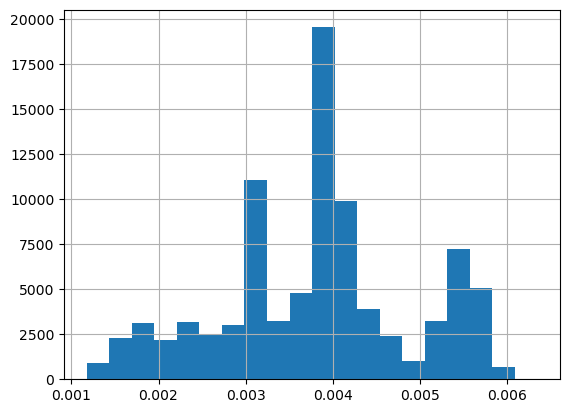

In [10]:
train.cltv1.hist(bins=20)

<AxesSubplot:>

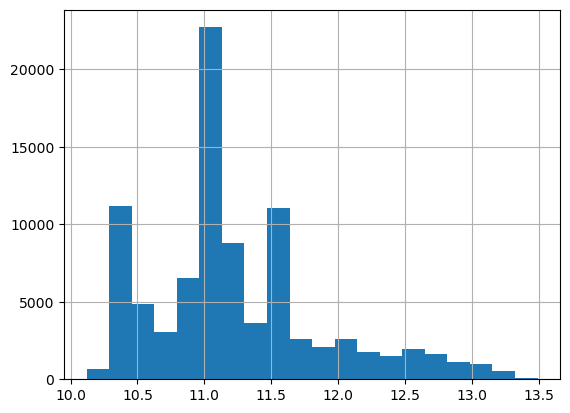

In [11]:
train.cltv2.hist(bins=20)

In [12]:
## Data Exploration

In [13]:
df = pd.concat([train, test], axis=0).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148987 entries, 0 to 148986
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              148987 non-null  int64  
 1   gender          148987 non-null  object 
 2   area            148987 non-null  object 
 3   qualification   148987 non-null  object 
 4   income          148987 non-null  object 
 5   marital_status  148987 non-null  int64  
 6   vintage         148987 non-null  int64  
 7   claim_amount    148987 non-null  int64  
 8   num_policies    148987 non-null  object 
 9   policy          148987 non-null  object 
 10  type_of_policy  148987 non-null  object 
 11  cltv            89392 non-null   float64
 12  cltv1           89392 non-null   float64
 13  cltv2           89392 non-null   float64
dtypes: float64(3), int64(4), object(7)
memory usage: 15.9+ MB


In [14]:
df.isnull().sum()

id                    0
gender                0
area                  0
qualification         0
income                0
marital_status        0
vintage               0
claim_amount          0
num_policies          0
policy                0
type_of_policy        0
cltv              59595
cltv1             59595
cltv2             59595
dtype: int64

In [15]:
df.describe()

,id,marital_status,vintage,claim_amount,cltv,cltv1,cltv2
count,148987.000000,148987.000000,148987.000000,148987.000000,89392.000000,89392.000000,89392.000000
mean,74494.000000,0.576064,4.605523,4358.303201,97952.828978,0.003808,11.237349
std,43008.986615,0.494182,2.287299,3272.692800,90613.814793,0.001096,0.650748
min,1.000000,0.000000,0.000000,0.000000,24828.000000,0.001175,10.119768
25%,37247.500000,0.000000,3.000000,2402.000000,52836.000000,0.003109,10.874967
50%,74494.000000,1.000000,5.000000,4095.000000,66396.000000,0.003881,11.103407
75%,111740.500000,1.000000,6.000000,6098.000000,103440.000000,0.004350,11.546757
max,148987.000000,1.000000,8.000000,32534.000000,724068.000000,0.006346,13.492642


<AxesSubplot:>

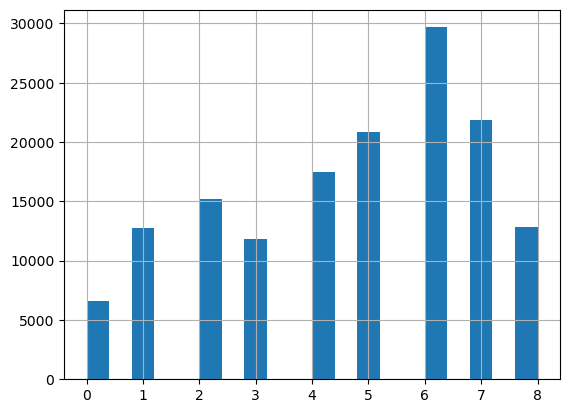

In [16]:
df.vintage.hist(bins=20)

<AxesSubplot:>

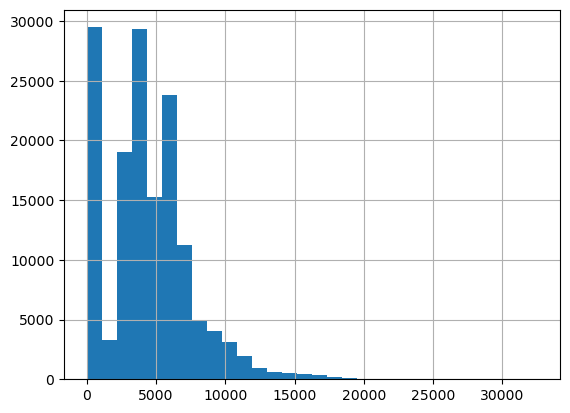

In [17]:
df.claim_amount.hist(bins=30)

In [18]:
## Exploring categorial categorical 
df.columns

Index(['id', 'gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage', 'claim_amount', 'num_policies', 'policy', 'type_of_policy',
       'cltv', 'cltv1', 'cltv2'],
      dtype='object')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148987 entries, 0 to 148986
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              148987 non-null  int64  
 1   gender          148987 non-null  object 
 2   area            148987 non-null  object 
 3   qualification   148987 non-null  object 
 4   income          148987 non-null  object 
 5   marital_status  148987 non-null  int64  
 6   vintage         148987 non-null  int64  
 7   claim_amount    148987 non-null  int64  
 8   num_policies    148987 non-null  object 
 9   policy          148987 non-null  object 
 10  type_of_policy  148987 non-null  object 
 11  cltv            89392 non-null   float64
 12  cltv1           89392 non-null   float64
 13  cltv2           89392 non-null   float64
dtypes: float64(3), int64(4), object(7)
memory usage: 15.9+ MB


In [20]:
cat_cols = ['gender', 'area', 'qualification', 'income', 'marital_status', 'num_policies', 'policy', 'type_of_policy']
len(cat_cols)

8

In [21]:
for x in cat_cols :
    print(df[x].value_counts())

Male      84138
Female    64849
Name: gender, dtype: int64
Urban    103896
Rural     45091
Name: area, dtype: int64
High School    77082
Bachelor       65752
Others          6153
Name: qualification, dtype: int64
5L-10L           87804
2L-5L            35218
More than 10L    22827
<=2L              3138
Name: income, dtype: int64
1    85826
0    63161
Name: marital_status, dtype: int64
More than 1    100571
1               48416
Name: num_policies, dtype: int64
A    94515
B    41083
C    13389
Name: policy, dtype: int64
Platinum    79704
Silver      35063
Gold        34220
Name: type_of_policy, dtype: int64


[Text(0.5, 1.0, 'Frequency distribution of income')]

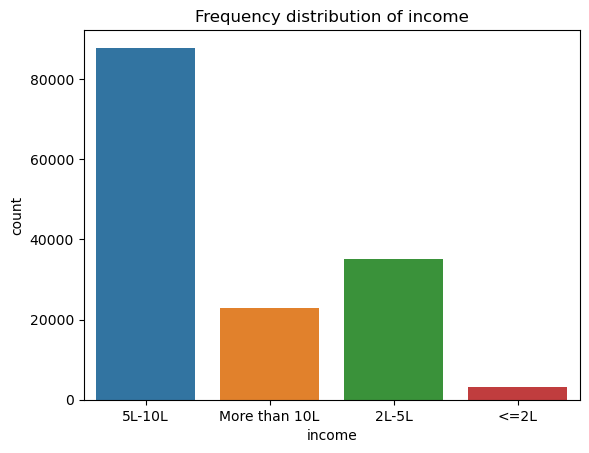

In [23]:
import seaborn as sns
col = 'income'
sns.countplot(x=col, data=df).set(title="Frequency distribution of income")

[Text(0.5, 1.0, 'Frequency distribution of policy')]

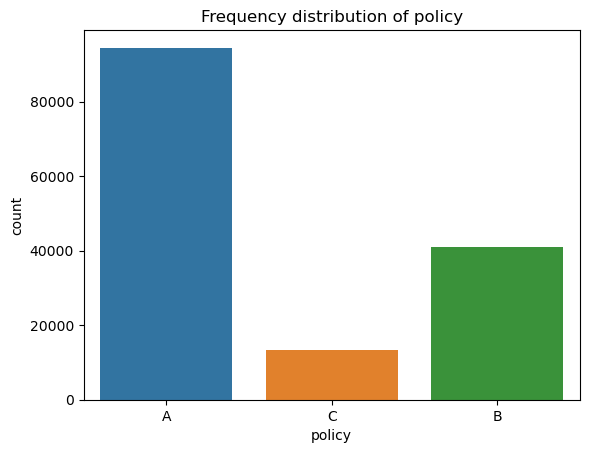

In [24]:
col = 'policy'
sns.countplot(x=col, data=df).set(title="Frequency distribution of policy")

[Text(0.5, 1.0, 'Frequency distribution of policy')]

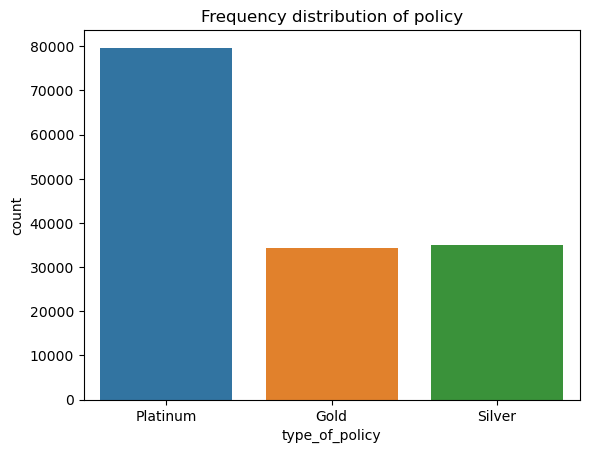

In [25]:
col = 'type_of_policy'
sns.countplot(x=col, data=df).set(title="Frequency distribution of policy")

In [26]:
## Data Prep

In [27]:
df['claim_amount_cat'] = pd.cut(df.claim_amount, [0,2000,4000,6000,8000,10000,50000],labels = ['A1','A2','A3','A4','A5','A6'], include_lowest=True)
df['var1'] = df['claim_amount'] / (df['vintage']+1)


df['vintage1'] = df['vintage'].apply(lambda x :'V'+str(x))
data = df[['gender', 'area', 'qualification', 'income', 'marital_status',
       'vintage1', 'num_policies', 'policy', 'type_of_policy',
     'claim_amount_cat']]
kmode = KModes(n_clusters=7, init = "random", n_init = 5, verbose=1)
cluster = kmode.fit_predict(data)
df['cluster'] = cluster 
df['cluster'] = df['cluster'].apply(lambda x : 'C'+str(x))

cat_feats = [ 'gender', 'area', 'qualification', 'income', 'num_policies', 'policy', 'type_of_policy',
        'claim_amount_cat', 'cluster']
for c in cat_feats:
    df[c] = df[c].astype('category')
    
train, test  = df[:train.shape[0]].reset_index(drop=True), df[train.shape[0]:].reset_index(drop=True)
features = [c for c in train.columns if c not in ['id' ,'cltv','vintage1','avg_claim_amt']]
target = train['cltv']
features

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 11506, cost: 545720.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 48212, cost: 525742.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 24465, cost: 520872.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 46614, cost: 508398.0
Run 4, iteration: 2/100, moves: 5302, cost: 508398.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 32529, cost: 501473.0
Run 5, iteration: 2/100, moves: 1744, cost: 501473.0
Best run was number 5


['gender',
 'area',
 'qualification',
 'income',
 'marital_status',
 'vintage',
 'claim_amount',
 'num_policies',
 'policy',
 'type_of_policy',
 'cltv1',
 'cltv2',
 'claim_amount_cat',
 'var1',
 'cluster']

In [76]:
### lgbm (10 fold - no transformation on dependent var)

In [91]:
training_start_time = time.time()

folds = StratifiedKFold(n_splits = 10)
train_prediction = np.zeros(len(train))
test_prediction = np.zeros(len(test))


for fold_, (train_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_train, y_train = train.iloc[train_idx][features], target.iloc[train_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    print(X_train.shape[1], X_val.shape[1])

    lgbm = LGBMRegressor(bagging_fraction=0.7, bagging_freq=5, feature_fraction=0.9,
              learning_rate=0.01, min_child_samples=90, min_split_gain=0.7,
              n_estimators=10000, num_leaves=10, random_state=123,
              reg_alpha=0.0001, reg_lambda=0.1)
#     lgbm  = LGBMRegressor(bagging_fraction=0.9, bagging_freq=0, boosting_type='gbdt',
#               class_weight=None, colsample_bytree=1.0, feature_fraction=0.8,
#               importance_type='split', learning_rate=0.1, max_depth=-1,
#               min_child_samples=36, min_child_weight=0.001, min_split_gain=0.1,
#               n_estimators=10000, n_jobs=-1, num_leaves=100, objective=None,
#               random_state=1234, reg_alpha=0.005, reg_lambda=0.05,
#               silent='warn', subsample=1.0, subsample_for_bin=200000,
#               subsample_freq=0)
# 
    _ = lgbm.fit(X_train, y_train, categorical_feature=cat_feats,eval_set = [(X_val, y_val)], verbose=100, early_stopping_rounds=500, eval_metric='rmse')
#     _ = lgbm.fit(X_train, y_train, eval_set = [(X_val, y_val)], verbose=100, early_stopping_rounds=500, eval_metric='rmse')

    train_prediction[val_idx] = lgbm.predict(X_val)
    current_test_pred = lgbm.predict(X_test)
    test_prediction += lgbm.predict(X_test)/10
    
    
    print(f'\n Fold {rmse(y_val, train_prediction[val_idx])}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\ntrain score (validation fold) : {rmse(np.log(target), np.log(train_prediction))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total  time: {(total_training_time)//60} minutes ')

lgbm_prediction = test_prediction


---- Fold 0 -----

13 13
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[100]	valid_0's rmse: 83365.3	valid_0's l2: 6.94977e+09
[200]	valid_0's rmse: 82310.4	valid_0's l2: 6.775e+09
[300]	valid_0's rmse: 82129.2	valid_0's l2: 6.74521e+09
[400]	valid_0's rmse: 82085	valid_0's l2: 6.73794e+09
[500]	valid_0's rmse: 82081.5	valid_0's l2: 6.73738e+09
[600]	valid_0's rmse: 82082	valid_0's l2: 6.73746e+09
[700]	valid_0's rmse: 82091.2	valid_0's l2: 6.73897e+09
[800]	valid_0's rmse: 82093.2	valid_0's l2: 6.73929e+09
[900]	valid_0's rmse: 82104.3	valid_0's l2: 6.74112e+09
[1000]	valid_0's rmse: 82111.2	valid_0's l2: 6.74225e+09

 Fold 82077.21969295359

->-> Fold ran for 0 minutes 5 seconds

---- 

[100]	valid_0's rmse: 83174.4	valid_0's l2: 6.91798e+09
[200]	valid_0's rmse: 81957.4	valid_0's l2: 6.71702e+09
[300]	valid_0's rmse: 81689.1	valid_0's l2: 6.67311e+09
[400]	valid_0's rmse: 81610.4	valid_0's l2: 6.66026e+09
[500]	valid_0's rmse: 81573.5	valid_0's l2: 6.65424e+09
[600]	valid_0's rmse: 81566.7	valid_0's l2: 6.65313e+09
[700]	valid_0's rmse: 81558.5	valid_0's l2: 6.65179e+09
[800]	valid_0's rmse: 81554.5	valid_0's l2: 6.65114e+09
[900]	valid_0's rmse: 81550.4	valid_0's l2: 6.65046e+09
[1000]	valid_0's rmse: 81555.8	valid_0's l2: 6.65135e+09
[1100]	valid_0's rmse: 81554.7	valid_0's l2: 6.65117e+09
[1200]	valid_0's rmse: 81564.4	valid_0's l2: 6.65275e+09
[1300]	valid_0's rmse: 81568.2	valid_0's l2: 6.65337e+09

 Fold 81546.40949121935

->-> Fold ran for 0 minutes 7 seconds

---- Fold 9 -----

13 13
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subs

In [92]:
sub = pd.read_csv(test_data)
sub['cltv']= lgbm_prediction
#creating the sample submission file
sample_submission = sub[['id','cltv']]
sample_submission.to_csv("lgbm_93.csv",index=False)
# 0.158772592024677

In [93]:
feature_imp = pd.DataFrame({'Value':lgbm.feature_importances_,'Feature':features})
feature_imp = feature_imp.sort_values(by='Value')
feature_imp

,Value,Feature
10,161,claim_amount_cat
5,216,vintage
9,217,type_of_policy
0,223,gender
1,249,area
2,279,qualification
4,339,marital_status
7,452,num_policies
3,489,income
12,562,cluster


In [94]:
train.corr()

,id,marital_status,vintage,claim_amount,cltv,var1,avg_claim_amt
id,1.000000,0.000171,-0.005824,0.003634,-0.004223,0.004471,-0.000656
marital_status,0.000171,1.000000,-0.011686,-0.114924,-0.077744,-0.068831,-0.195771
vintage,-0.005824,-0.011686,1.000000,0.009579,0.020608,-0.520231,-0.018773
claim_amount,0.003634,-0.114924,0.009579,1.000000,0.180344,0.605392,0.374621
cltv,-0.004223,-0.077744,0.020608,0.180344,1.000000,0.094732,0.117967
var1,0.004471,-0.068831,-0.520231,0.605392,0.094732,1.000000,0.238939
avg_claim_amt,-0.000656,-0.195771,-0.018773,0.374621,0.117967,0.238939,1.000000


In [95]:
### GBM

In [96]:
from sklearn.ensemble import GradientBoostingRegressor


In [97]:
train = pd.get_dummies(train[features])
test = pd.get_dummies(test[features])
features = train.columns
train.shape , test.shape

((89392, 36), (59595, 36))

In [101]:
training_start_time = time.time()

folds = StratifiedKFold(n_splits = 10)
train_prediction = np.zeros(len(train))
test_prediction = np.zeros(len(test))


for fold_, (train_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_train, y_train = train.iloc[train_idx][features], target.iloc[train_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    print(X_train.shape[1], X_val.shape[1])

    gbm = GradientBoostingRegressor(learning_rate=0.01, loss='ls', max_depth=7,
                          max_features='sqrt', min_impurity_decrease=0.05,
                          min_samples_leaf=2, n_estimators=200,
                          random_state=123, subsample=0.7)
    
    _ = gbm.fit(X_train, y_train)
    train_prediction[val_idx] = gbm.predict(X_val)
    current_test_pred = gbm.predict(X_test)
    test_prediction += gbm.predict(X_test)/10
    
    
#     print(f'\n Fold {rmse(y_val) ,train_prediction[val_idx]}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\ntrain score (validation fold) : {rmse(np.log(target), np.log(train_prediction))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total  time: {(total_training_time)//60} minutes ')

gbm_prediction = test_prediction


---- Fold 0 -----

36 36

->-> Fold ran for 0 minutes 21 seconds

---- Fold 1 -----

36 36

->-> Fold ran for 0 minutes 21 seconds

---- Fold 2 -----

36 36

->-> Fold ran for 0 minutes 21 seconds

---- Fold 3 -----

36 36

->-> Fold ran for 0 minutes 21 seconds

---- Fold 4 -----

36 36

->-> Fold ran for 0 minutes 21 seconds

---- Fold 5 -----

36 36

->-> Fold ran for 0 minutes 21 seconds

---- Fold 6 -----

36 36

->-> Fold ran for 0 minutes 22 seconds

---- Fold 7 -----

36 36

->-> Fold ran for 0 minutes 21 seconds

---- Fold 8 -----

36 36

->-> Fold ran for 0 minutes 22 seconds

---- Fold 9 -----

36 36

->-> Fold ran for 0 minutes 22 seconds

train score (validation fold) : 0.5720440750178357

->-> Total  time: 3 minutes 


In [102]:
sub = pd.read_csv(test_data)
sub['cltv']= gbm_prediction
#creating the sample submission file
sample_submission = sub[['id','cltv']]
sample_submission.to_csv("gbm_93.csv",index=False)
# 0.158772592024677

In [104]:
## Ridge Regression
from sklearn.linear_model import Ridge

In [107]:
training_start_time = time.time()

folds = StratifiedKFold(n_splits = 10)
train_prediction = np.zeros(len(train))
test_prediction = np.zeros(len(test))


for fold_, (train_idx, val_idx) in enumerate(folds.split(train, pd.qcut(target, 10, labels=False))):
    
    print(f'\n---- Fold {fold_} -----\n')
    
    fold_start_time = time.time()
    
    X_train, y_train = train.iloc[train_idx][features], target.iloc[train_idx]
    X_val, y_val = train.iloc[val_idx][features], target.iloc[val_idx]
    X_test = test[features]
    print(X_train.shape[1], X_val.shape[1])

    ridge = Ridge(alpha=1.8)
    
    _ = ridge.fit(X_train, y_train)
    train_prediction[val_idx] = ridge.predict(X_val)
    current_test_pred = ridge.predict(X_test)
    test_prediction += ridge.predict(X_test)/10
    
    
#     print(f'\n Fold {rmse(y_val) ,train_prediction[val_idx]}')
    
    fold_end_time = time.time()
    total_fold_time = int(fold_end_time - fold_start_time)
    
    print(f"\n->-> Fold ran for {(total_fold_time)//60} minutes {(total_fold_time)%60} seconds")
    

print(f'\ntrain score (validation fold) : {rmse(np.log(target), np.log(train_prediction))}')
training_end_time = time.time()
total_training_time = int(training_end_time - training_start_time)

print(f'\n->-> Total  time: {(total_training_time)//60} minutes ')

ridge_prediction = test_prediction


---- Fold 0 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 1 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 2 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 3 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 4 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 5 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 6 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 7 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 8 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

---- Fold 9 -----

36 36

->-> Fold ran for 0 minutes 0 seconds

train score (validation fold) : 0.5781493030355901

->-> Total  time: 0 minutes 


In [108]:
sub = pd.read_csv(test_data)
sub['cltv']= ridge_prediction
#creating the sample submission file
sample_submission = sub[['id','cltv']]
sample_submission.to_csv("ridge_93.csv",index=False)

In [118]:
### Combine rige , gbm  , lgbm
ridge = pd.read_csv("ridge_93.csv")
gbm = pd.read_csv("gbm_93.csv")
lgbm = pd.read_csv("lgbm_93.csv")


sub = pd.read_csv(test_data)
sub['cltv']= 0.2*ridge['cltv'] + 0.2*gbm['cltv'] + 0.6*lgbm['cltv'] 
#creating the sample submission file
sample_submission = sub[['id','cltv']]
sample_submission.to_csv("ridge_lgbm_gbm_keras_93.csv",index=False)